# Embeddings Comparison

The idea is that we want to see if BERT produces ultrametric-like embeddings. Probabilistically, it should.

We create NUMBER_OF_TRIALS trials. Each trial has between FEWEST_EXEMPLARS and MOST_EXAMPLARS exemplars randomly
selected from monosemous (single-meaning) words.

For each trial we look at the whole vocabulary, and assign each word in the vocabulary to the nearest exemplar.
We do this using wordnet, BERT, GloVe and Word2vec.

Hopefully one day I'll turn this into something p-adic too.

In [1]:
NUMBER_OF_TRIALS = 100
FEWEST_EXEMPLARS = 5
MOST_EXEMPLARS = 100

There's a `requirements.txt` file in this folder on git. You can also set up a virtualenv and install
the dependencies there.

In [40]:
!pip install transformers
!pip install nltk
!pip install gensim
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import nltk
from nltk.corpus import wordnet as wn
import random
import torch
from transformers import BertTokenizer, BertModel
import tqdm
import collections
from scipy.spatial.distance import cosine
import pandas
import matplotlib.pyplot
import seaborn
import numpy
from gensim.models import Word2Vec 
import gensim.downloader

On my Linux box I had some problems with some of these downloads. They work fine, just not in the Jupyter notebook.
So there's another script in this folder called `download.py`. You can run that first if you hit errors where
Jupyter can't start the progress widget

## Wordnet data

In [35]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/minigadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/minigadi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## BERT data

In [3]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Copied from https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d
    
    Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Word2vec and GloVe

See the note above about using `download.py` if you have problems.

These are simpler because we don't need the whole model.

In [6]:
w2v_model = gensim.downloader.load('word2vec-google-news-300')
glove_model = gensim.downloader.load('glove-twitter-25')

# Vocabulary Creation

What words are we going to use in this exercise?

- Nouns, excluding proper nouns
- That have only a single meaning
- That appear in Wordnet, BERT, Glove and Word2Vec

In [7]:
%%time
missing_from_bert = 0
missing_from_word2vec = 0
missing_from_glove = 0
monosemous_nouns = {}
for word in wn.all_lemma_names():
    if '_' in word:
        continue
    synsets = wn.synsets(word)
    if len(synsets) != 1:
        # Single meaning only, please
        continue
    synset = synsets[0]
    if synset.pos() != 'n':
        # Nouns only please
        continue
    if len(synset.instance_hypernyms()) > 0 or len(synset.instance_hyponyms()) > 0:
        # Presumably that's a proper noun. I wish there were a better way to detect that
        continue
    # Are you obscure?
    must_skip = False
    if word not in tokenizer.vocab:
        missing_from_bert += 1
        must_skip = True
    if word not in w2v_model:
        missing_from_word2vec += 1
        must_skip = True
    if word not in glove_model:
        missing_from_glove += 1
        must_skip = True
    if must_skip:
        continue
    # All right. You may pass.
    monosemous_nouns[word] = synsets[0]
(missing_from_bert, missing_from_word2vec, missing_from_glove)

CPU times: user 6.97 s, sys: 140 ms, total: 7.11 s
Wall time: 7.11 s


(31741, 18205, 23512)

In [8]:
monosemous_nouns_list = list(monosemous_nouns)
len(monosemous_nouns_list)

1621

In [9]:
#working_subset_of_nouns = random.sample(monosemous_nouns_list, MOST_EXEMPLARS * 5)
working_subset_of_nouns = monosemous_nouns_list[:]

BERT is fussy. It has to be *just right* or else it can't generate an embedding.

In [10]:
bert_embeddings = {}
for word in working_subset_of_nouns:
    marked_text = "[CLS] "
    marked_text += word.replace('_', ' ')
    marked_text += " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    bert_embeddings[word] = list_token_embeddings[0]

# The Isolation Kernel Algorithm

This is Ye Zhu's O(N) clustering algorithm that works even when the dataset has varying density:

- Pick a few samples. For each data point, see which sample they are closest to.
- Repeat that step again many times, choosing different samples each time.
- Two points that share a "closest samples" regularly must be very similar / very close. 

The only odd thing here is that we are doing this across multiple algorithms.

----
There are a couple of other Wordnet similarity algorithms I chould use. e.g. Should I use Resnik similarity?

Currently not bothering, because wordnet similarity scores are fairly strongly correlated to each other (as you
would expect).

I could probably clean up this next cell a lot. Storing the trials in a database would be a good first step.

In [14]:
trials = []
for trial_number in tqdm.tqdm(range(NUMBER_OF_TRIALS)):
    exemplar_count = random.randrange(FEWEST_EXEMPLARS, MOST_EXEMPLARS)
    exemplar_words = random.sample(working_subset_of_nouns, k=exemplar_count)
    exemplar_synsets = [monosemous_nouns[w] for w in exemplar_words]
    exemplars = {w:s for (w,s) in zip(exemplar_words, exemplar_synsets)}
    exemplar_embeddings = {w:bert_embeddings[w] for w in exemplar_words}
    trial = {'exemplar_count': exemplar_count,
             'exemplar_words': exemplar_words,
             'wordnet_path_similarity_neighbours': {},
             'wordnet_wup_neighbours': {},
             'bert_cosine_neighbours': {},
             'bert_dot_product_neighbours': {},
             'word2vec_neighbours': {},
             'glove_neighbours': {} 
            }
    for word, synset in monosemous_nouns.items():
        if word not in working_subset_of_nouns:
            continue

        for (dict_name, wn_func) in [('wordnet_path_similarity_neighbours', wn.path_similarity), 
                                     ('wordnet_wup_neighbours', wn.wup_similarity)]:
            best_exemplar = None
            best_score = 0.0
            for e_word, e_synset in exemplars.items():
                similarity = max(wn_func(synset, e_synset), wn.path_similarity(e_synset, synset))
                if similarity > best_score:
                    best_exemplar = e_word
                    best_score = similarity
            trial[dict_name][word] = best_exemplar
        
        
        best_exemplar = None
        best_score = 0.0
        word_embedding = bert_embeddings[word]
        for e_word, e_embedding in exemplar_embeddings.items():
            distance = 1 - cosine(word_embedding, e_embedding)
            if distance > best_score:
                best_exemplar = e_word
                best_score = distance
        trial['bert_cosine_neighbours'][word] = best_exemplar
        best_exemplar = None
        best_score = 0.0
        word_embedding = bert_embeddings[word]
        for e_word, e_embedding in exemplar_embeddings.items():
            distance = numpy.dot(word_embedding, e_embedding)
            if distance > best_score:
                best_exemplar = e_word
                best_score = distance
        trial['bert_dot_product_neighbours'][word] = best_exemplar

        best_exemplar = None
        best_score = 0.0
        word_embedding = w2v_model[word]
        for e_word in exemplar_words:
            distance = numpy.dot(word_embedding, w2v_model[e_word])
            if distance > best_score:
                best_exemplar = e_word
                best_score = distance
        trial['word2vec_neighbours'][word] = best_exemplar
 

        best_exemplar = None
        best_score = 0.0
        word_embedding = glove_model[word]
        for e_word in exemplar_words:
            distance = numpy.dot(word_embedding, glove_model[e_word])
            if distance > best_score:
                best_exemplar = e_word
                best_score = distance
        trial['glove_neighbours'][word] = best_exemplar
        
        
        
    trials.append(trial)

100%|███████████████████████████████████████| 100/100 [1:50:57<00:00, 66.57s/it]


# Analysis

The idea behind this work was to ask whether BERT / GloVe / Word2Vec would show similar clustering behaviour
to WordNet.

First up: did anything silly happen during the data crunching phase? Did we get a strange number of exemplars,
or anything like that?

<AxesSubplot:title={'center':'Number of exemplars in series'}, ylabel='Frequency'>

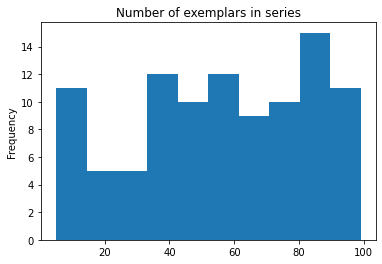

In [15]:
pandas.Series([x['exemplar_count'] for x in trials]).plot.hist(title="Number of exemplars in series")

These functions extracts the data from the trials. `neighbour_analyses` returns a dataframe with columns
`w1`, `w2` and the co-exemplar counts.

In [21]:
def neighbour_analysis(trials, neighbour_key, column_name=None):
    neighbour_dicts = [x[neighbour_key] for x in trials]
    word_similarities = []
    # I could perhaps be more efficient here. But quadratic time for <100,000 entries is not super-terrible.
    for w1 in working_subset_of_nouns:
        for w2 in working_subset_of_nouns:
            if w2 <= w1:
                continue
            coexemplar_count = 0
            for d in neighbour_dicts:
                if d[w1] == d[w2]:
                    coexemplar_count += 1
            if coexemplar_count > 0:
                word_similarities.append({'word1': w1, 'word2': w2, 'coexemplar_count': coexemplar_count})
    answer = pandas.DataFrame.from_records(word_similarities)
    if column_name is None:
        column_name = neighbour_key.replace('_neighbours', '_exemplar_count')
    answer.rename(columns={'coexemplar_count': column_name}, inplace=True)
    return answer
    #inverted_dicts = []
    #for d in neighbour_dicts:
    #    this_inverted_dict = collections.defaultdict(set)
    #    for k,v in d.items():
    #        this_inverted_dict[v].update([k])
    #    inverted_dicts.append(this_inverted_dict)
    #return inverted_dicts

    
def neighbour_analyses(trials, neighbour_keys):
    df = None
    while len(neighbour_keys) > 0:
        that_df = neighbour_analysis(trials, neighbour_keys[0])
        if df is None:
            df = that_df
        else:
            df = df.merge(that_df, how="outer", on=['word1', 'word2'])
        neighbour_keys = neighbour_keys[1:]
    return df

In [22]:
all_neighbour_methods = ['wordnet_path_similarity_neighbours','wordnet_wup_neighbours',
                         'bert_cosine_neighbours', 'bert_dot_product_neighbours', 
                         'word2vec_neighbours', 'glove_neighbours']
all_df_columns = [x.replace('_neighbours', '_exemplar_count') for x in all_neighbour_methods]

In [23]:
%%time
df = neighbour_analyses(trials, all_neighbour_methods)
#.fillna(0)
df.sample(10, random_state=12345)

CPU times: user 1min 17s, sys: 668 ms, total: 1min 18s
Wall time: 1min 18s


,word1,word2,wordnet_path_similarity_exemplar_count,wordnet_wup_exemplar_count,bert_cosine_exemplar_count,bert_dot_product_exemplar_count,word2vec_exemplar_count,glove_exemplar_count
88524,archery,cameo,2.0,NaN,NaN,4.0,NaN,6.0
1036316,congressman,victory,NaN,NaN,9.0,26.0,5.0,8.0
1287628,furnace,kgb,NaN,NaN,NaN,NaN,1.0,11.0
423196,draper,mattress,2.0,2.0,24.0,33.0,2.0,2.0
832563,periphery,shaman,1.0,NaN,5.0,2.0,3.0,9.0
129634,bacteria,idiot,72.0,93.0,2.0,1.0,2.0,1.0
855268,prestige,sheikh,1.0,NaN,22.0,33.0,5.0,2.0
325404,cornerback,subsidy,2.0,NaN,39.0,62.0,1.0,6.0
1004516,bribery,cassie,NaN,NaN,4.0,6.0,2.0,NaN
185774,blindness,congressman,1.0,NaN,NaN,1.0,3.0,1.0


## Distribution of data

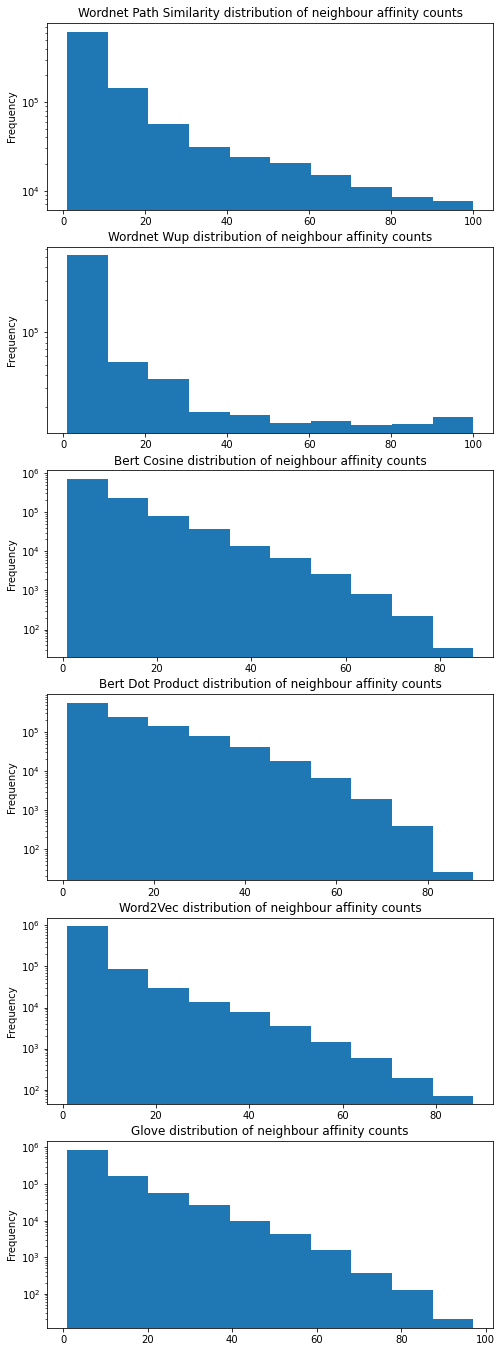

In [26]:
fig, axes = matplotlib.pyplot.subplots(nrows=len(all_neighbour_methods), figsize=(8,4*len(all_neighbour_methods)))
for i,name in enumerate(all_df_columns):
    df[name].plot.hist(logy=True, ax=axes[i])
    title = name.replace('_exemplar_count','').replace('_', ' ').title()
    axes[i].set_title(f"{title} distribution of neighbour affinity counts")

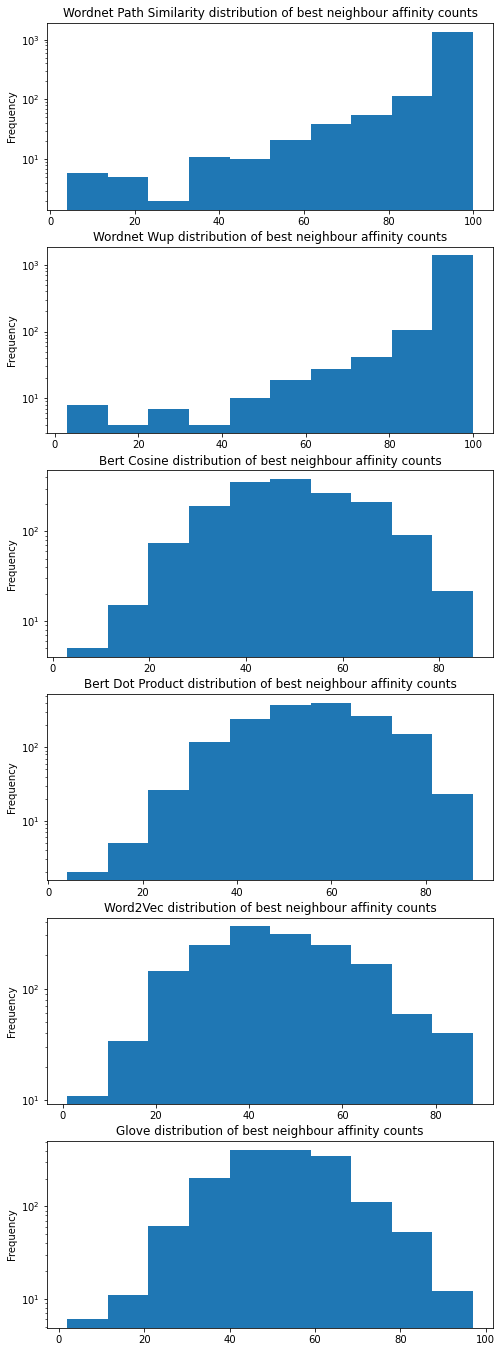

In [31]:
fig, axes = matplotlib.pyplot.subplots(nrows=len(all_neighbour_methods), figsize=(8,4*len(all_neighbour_methods)))
for i,name in enumerate(all_df_columns):
    df.groupby('word1')[name].max().plot.hist(logy=True, ax=axes[i])
    title = name.replace('_exemplar_count','').replace('_', ' ').title()
    axes[i].set_title(f"{title} distribution of best neighbour affinity counts")

# Results!

This is where I was hoping to see great correlation between everything.

In reality: it's meh and wuuut??

I think I'm forced to conclude that GloVe, BERT and Word2vec disagree on what words are similar to each other.

But... how?

<AxesSubplot:>

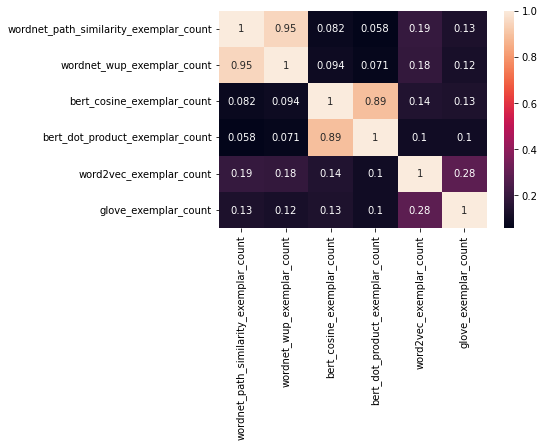

In [37]:
seaborn.heatmap(df.corr(), annot=True)

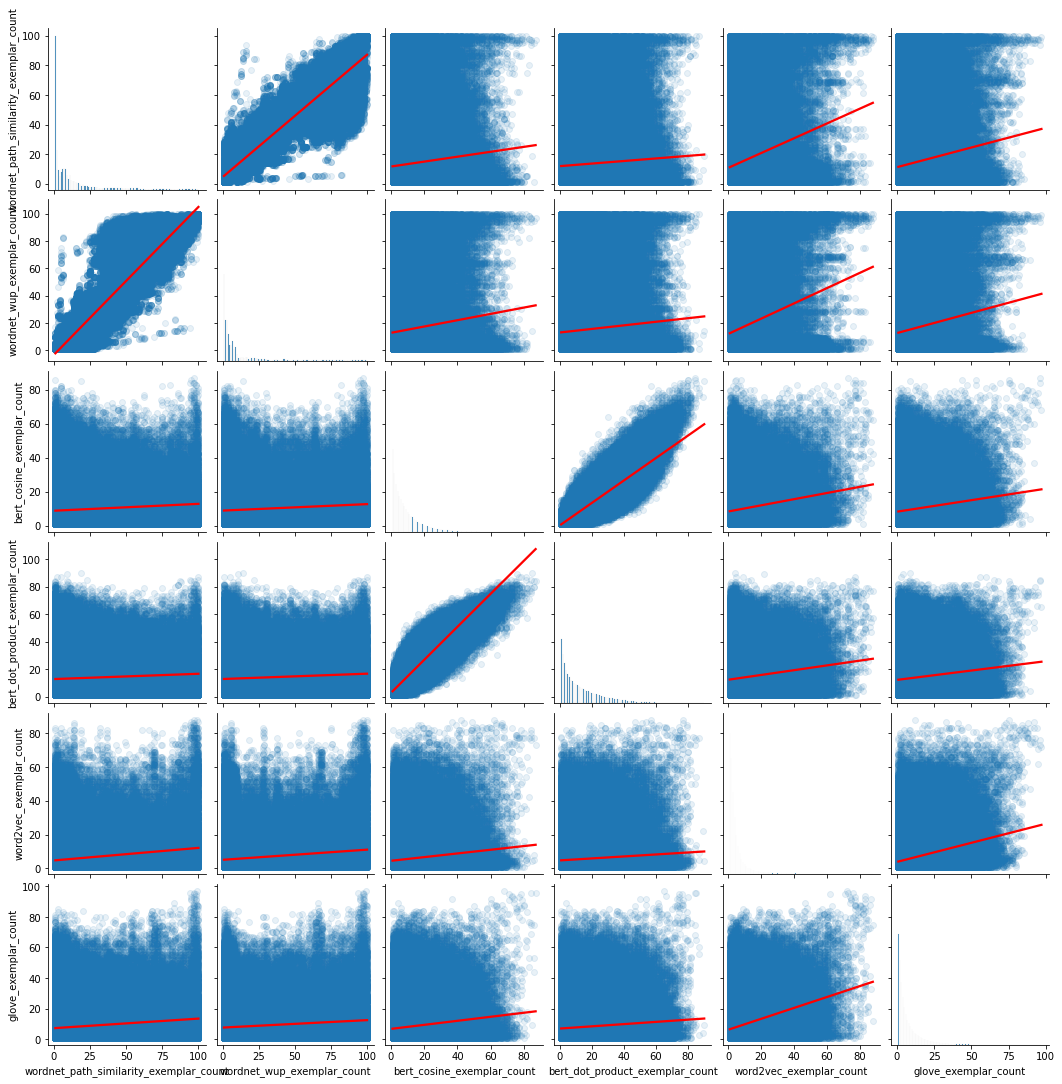

In [39]:
%%time
seaborn.pairplot(df, 
                 dropna=True,
                 kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

## Desperate last chance results

Is there even any agreement about what the outlier words are?

Spoiler: no.

In [50]:
def get_maxes(df, column):
    global working_subset_of_nouns
    z = pandas.DataFrame({'word1max': df.groupby('word1')[column].max(),
                         'word2max': df.groupby('word2')[column].max()})
    return z.apply(max, axis=1)

In [52]:
get_maxes(df, 'bert_cosine_exemplar_count').nsmallest(5)

surname        27.0
grandmaster    28.0
pe             29.0
streetcar      29.0
voyager        29.0
dtype: float64

In [55]:
get_maxes(df, 'wordnet_path_similarity_exemplar_count').nsmallest(5)

movie        56.0
cameo        60.0
entity       61.0
priestess    62.0
bakery       63.0
dtype: float64

In [56]:
get_maxes(df, 'word2vec_exemplar_count').nsmallest(5)

while       15.0
lieu        18.0
kgb         19.0
lifetime    19.0
might       20.0
dtype: float64

In [57]:
get_maxes(df, 'glove_exemplar_count').nsmallest(5)

urdu       26.0
havoc      27.0
tsunami    29.0
vertigo    29.0
cid        30.0
dtype: float64

# Conclusion

It seems that every word e